# Robotics Nanodegree
***

## Project: **Search and Sample Return** 
***

In this project, autonomous search and sample return based on computer vision will be implemented and the scene map will be generated.

This notebook provides the scaffolding needed to test out mapping methods. The steps are the following:

* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Write functions to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

## Set Up Session

### Turn on Code Highlighting in the Markdown Cells

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

### Fire Up 

In [2]:
# Configuration file:
from search_and_sample_return.utils.conf import Conf
# IO utilities:
import random
from os.path import basename, splitext
import json
import pickle
# Image processing:
import cv2
import numpy as np
# Task specific module:
from search_and_sample_return.binarizers import Binarizer
from search_and_sample_return.transformers import PerspectiveTransformer
from search_and_sample_return.mappers import RoverCoordMapper, RoverPolarMapper, WorldCoordMapper
from search_and_sample_return.utils.databucket import DataBucket
from search_and_sample_return.painters import BirdEyeViewPainter, WorldMapPainter
# Visualization:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 9)
# Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
#%matplotlib qt 
# Image IO utilities:
import scipy.misc
import glob  
import imageio
# imageio.plugins.ffmpeg.download()

### Load Configuration

In [3]:
conf = Conf("conf/conf.json")

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  

This basic dataset is enough to get you up and running but if you want to tune your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

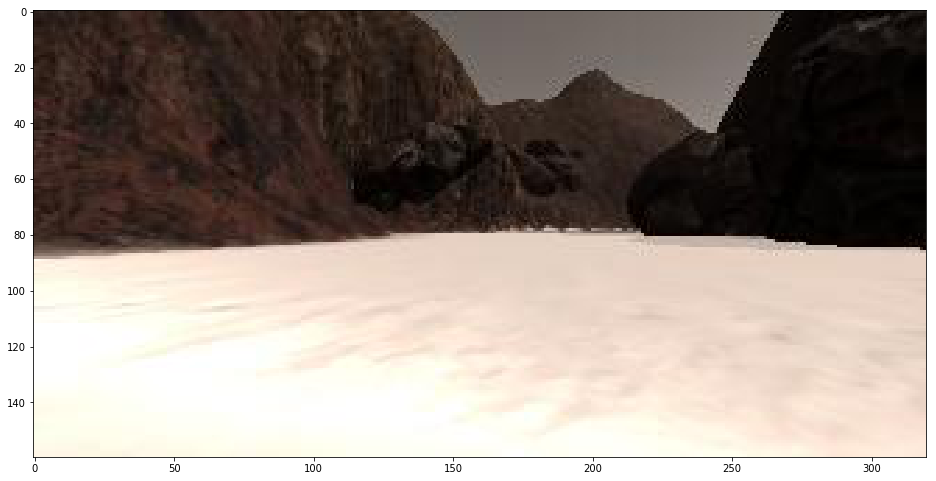

In [4]:
# Grab and display test images:
test_image_filenames = glob.glob(conf.test_dataset_images)
indices = np.random.choice(len(test_image_filenames), 1)
for index in indices:
    image = mpimg.imread(test_image_filenames[index])
    plt.imshow(image)

## Build Binarizer

***

Here binarizers for obstacles and rocks are built. Segmentation workflow for the two type of objects are the same and only parameters differ.

The detailed workflow is as follows:

0. Convert to **YUV** color space
1. Pixel values from ROI are extracted based on annotation results and parameters for color thresholding are determined through the analysis of **3D color histogram**
2. Threshold image and extract ROI based on color-space filtering
3. Combine **morphological open and close** operator to smooth the extracted ROI 


### Quick Look at the Ground&Obstacle and Rock

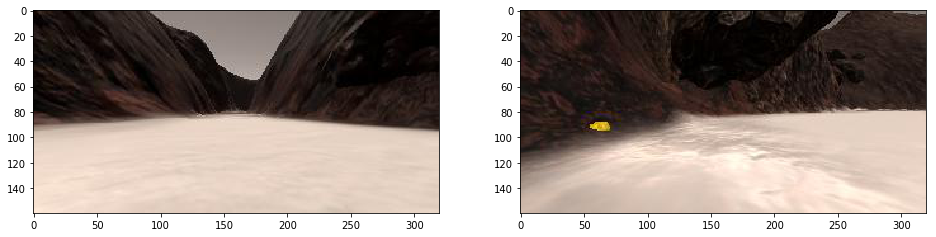

In [5]:
# In the simulator you can toggle on a grid on the ground for calibration by pressing G
# You can also toggle on the rock samples with the 0 (zero) key.  

# Ground & obstacle sample
image_sample_grid = mpimg.imread(
    random.choice(glob.glob(conf.binarizer_ground_test_images))
)
# Rock sample
image_sample_rock = mpimg.imread(
    random.choice(glob.glob(conf.binarizer_rock_test_images))
)

# Visualize:
fig = plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(image_sample_grid)
plt.subplot(122)
plt.imshow(image_sample_rock)

### Ground & Obstacle Segmentation

Below are parameters for YUV color space filtering & morphological kernel size:

```json
	"binarizer_ground_thresholds": [
		[160, 255],
		[128, 142],
		[112, 128]
	],
	"binarizer_ground_morphology_kernel_size": 7
```

In [6]:
# Build:
binarizer_ground = Binarizer(
    conf.binarizer_ground_thresholds,
    conf.binarizer_ground_morphology_kernel_size
)

# Save for deployment:
with open(conf.binarizer_ground_pickle, "wb") as binarizer_ground_pkl:
    pickle.dump(binarizer_ground, binarizer_ground_pkl)

In [7]:
# Load binarizers:
with open(conf.binarizer_ground_pickle, "rb") as binarizer_ground_pkl:
    binarizer_ground = pickle.load(binarizer_ground_pkl)

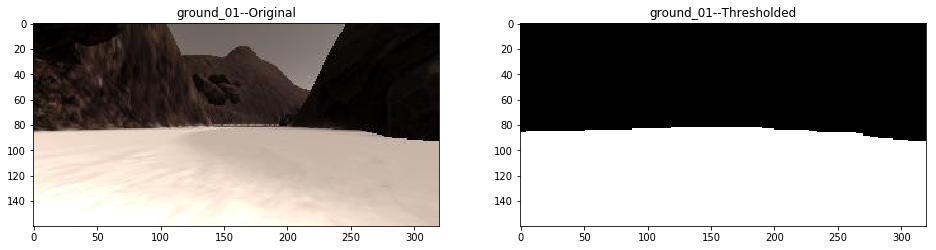

In [8]:
# Visualization:
for test_image_filename in sorted(glob.glob(conf.binarizer_ground_test_images))[:1]:
    # Original & thresholded:
    image_sample_original = cv2.imread(
        test_image_filename
    )
    image_sample_thresholded = binarizer_ground.transform(
        image_sample_original
    )
    
    # Initialize canvas:
    image_thresholding_demo = plt.figure(figsize=(16, 9))
    
    # Test image name:
    image_name, _ = splitext(basename(test_image_filename))
    
    # Original:
    ax=image_thresholding_demo.add_subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image_sample_original, cv2.COLOR_BGR2RGB))
    ax.set_title("{}--Original".format(image_name))
    # Rectified:
    ax=image_thresholding_demo.add_subplot(1,2,2)
    plt.imshow(image_sample_thresholded, cmap="gray")
    ax.set_title("{}--Thresholded".format(image_name))

### Rock Segmentation

Below are parameters for YUV color space filtering & morphological kernel size:

```json
	"binarizer_rock_thresholds": [
		[ 75, 150],
		[145, 170],
		[ 20,  80]
	],
	"binarizer_rock_morphology_kernel_size": 5
```

In [9]:
# Build:
binarizer_rock = Binarizer(
    conf.binarizer_rock_thresholds,
    conf.binarizer_rock_morphology_kernel_size
)

# Save for deployment:
with open(conf.binarizer_rock_pickle, "wb") as binarizer_rock_pkl:
    pickle.dump(binarizer_rock, binarizer_rock_pkl)

In [10]:
# Load binarizers:
with open(conf.binarizer_rock_pickle, "rb") as binarizer_rock_pkl:
    binarizer_rock = pickle.load(binarizer_rock_pkl)

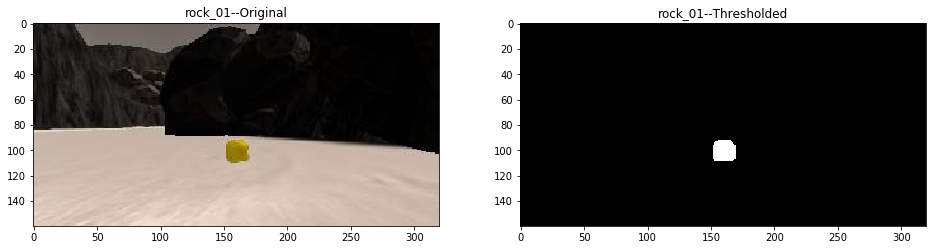

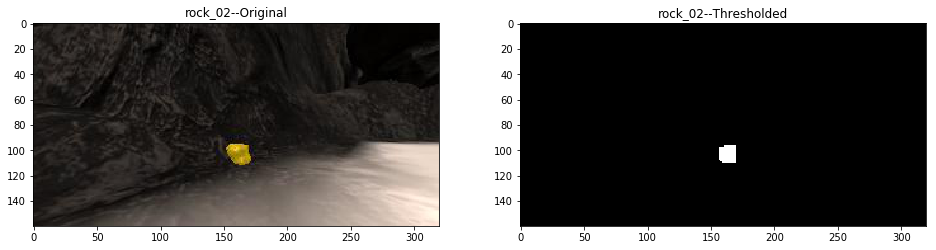

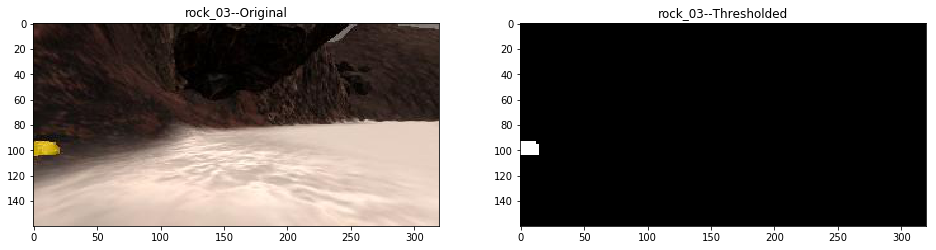

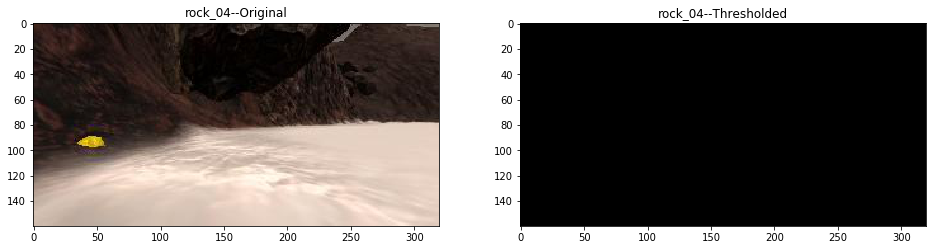

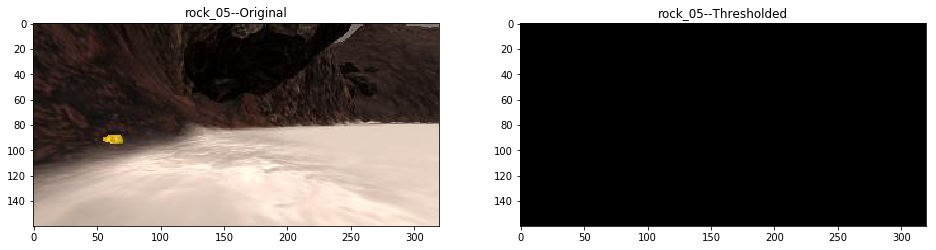

In [11]:
# Visualization:
for test_image_filename in sorted(glob.glob(conf.binarizer_rock_test_images)):
    # Original & thresholded:
    image_sample_original = cv2.imread(
        test_image_filename
    )
    image_sample_thresholded = binarizer_rock.transform(
        image_sample_original
    )
    
    # Initialize canvas:
    image_thresholding_demo = plt.figure(figsize=(16, 9))
    
    # Test image name:
    image_name, _ = splitext(basename(test_image_filename))
    
    # Original:
    ax=image_thresholding_demo.add_subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image_sample_original, cv2.COLOR_BGR2RGB))
    ax.set_title("{}--Original".format(image_name))
    # Rectified:
    ax=image_thresholding_demo.add_subplot(1,2,2)
    plt.imshow(image_sample_thresholded, cmap="gray")
    ax.set_title("{}--Thresholded".format(image_name))

## Build Pespective Transformer

***

Next the four-point pairs for perspective transform will be identified.

To select the appropriate four points for trapezoidal zone, I first annotated the grid image with annotation tool [Sloth](https://github.com/cvhciKIT/sloth)

Based on annotation results, my final four-point perspective transformation pairs are as follows:

```json
	"perspective_transformer_source": [
		[119.55,  96.55],
		[200.60,  96.55],
		[301.65, 140.60],
		[ 15.45, 140.60]
	],
	"perspective_transformer_destination": [
		[155, 140],
		[165, 140],
		[165, 150],
		[155, 150]
	]
```

The above parameters have all been saved in the json configuration file

In [12]:
# Build:
transformer = PerspectiveTransformer(
    conf.perspective_transformer_source,
    conf.perspective_transformer_destination,
    tuple(conf.frame_size)
)

# Save for deployment:
with open(conf.perspective_transformer_pickle, "wb") as transformer_pkl:
    pickle.dump(transformer, transformer_pkl)

In [13]:
# Load transformer:
with open(conf.perspective_transformer_pickle, "rb") as transformer_pkl:
    transformer = pickle.load(transformer_pkl)

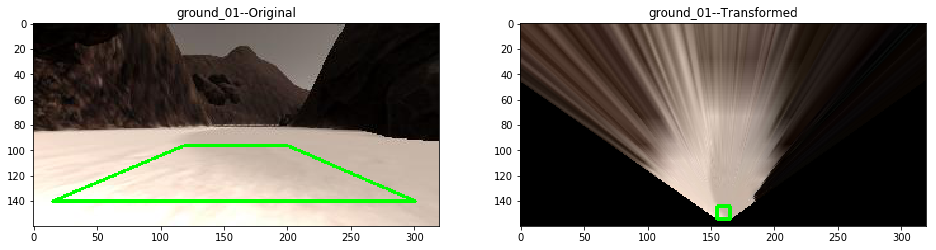

In [14]:
# Visualization:
for test_image_filename in sorted(glob.glob(conf.perspective_transformer_test_images))[:1]:
    # Original & thresholded:
    image_sample_original = cv2.imread(
        test_image_filename
    )
    image_sample_transformed = transformer.transform(
        image_sample_original
    )

    # Initialize canvas:
    perspective_transformation_demo = plt.figure(figsize=(16, 9))

    # Test image name:
    image_name, _ = splitext(basename(test_image_filename))
    
    # Original:
    ax=perspective_transformation_demo.add_subplot(1,2,1)
    plt.imshow(
        cv2.cvtColor(
            cv2.polylines(
                image_sample_original, 
                [
                    np.array(
                        conf.perspective_transformer_source,
                        dtype=np.int
                    )
                ], 
                True,
                (0, 255, 0),
                2
            ),
            cv2.COLOR_BGR2RGB
        )
    )
    ax.set_title("{}--Original".format(image_name))
    # Rectified:
    ax=perspective_transformation_demo.add_subplot(1,2,2)
    plt.imshow(
        cv2.cvtColor(
            cv2.polylines(
                image_sample_transformed, 
                [
                    np.array(
                        conf.perspective_transformer_destination,
                        dtype=np.int
                    )
                ], 
                True,
                (0, 255, 0),
                2
            ),
            cv2.COLOR_BGR2RGB
        )
    )
    ax.set_title("{}--Transformed".format(image_name))

## Build Mappers

***

Here the utility functions for coordinate transform from course tutorial are all wrapped up and refactored as Python classes

1. **RoverCoordMapper**: Map from pixel cooridnates to rover coordinates
2. **RoverPolarMapper**: Map from rover standard coordinates to rover polar coordinates 
3. **WorldCoordMapper**: Map from rover coordinates to world coordinates

In [15]:
# Build:
rover_coord_mapper = RoverCoordMapper(conf.frame_size)
rover_polar_mapper = RoverPolarMapper()
world_coord_mapper = WorldCoordMapper(conf.world_size)

# Save for deployment:
with open(conf.rover_coord_mapper_pickle, "wb") as rover_coord_mapper_pkl:
    pickle.dump(rover_coord_mapper, rover_coord_mapper_pkl)
with open(conf.rover_polar_mapper_pickle, "wb") as rover_polar_mapper_pkl:
    pickle.dump(rover_polar_mapper, rover_polar_mapper_pkl)
with open(conf.world_coord_mapper_pickle, "wb") as world_coord_mapper_pkl:
    pickle.dump(world_coord_mapper, world_coord_mapper_pkl)

In [16]:
# Load mappers:
with open(conf.rover_coord_mapper_pickle, "rb") as rover_coord_mapper_pkl:
    rover_coord_mapper = pickle.load(rover_coord_mapper_pkl)
with open(conf.rover_polar_mapper_pickle, "rb") as rover_polar_mapper_pkl:
    rover_polar_mapper = pickle.load(rover_polar_mapper_pkl)
with open(conf.world_coord_mapper_pickle, "rb") as world_coord_mapper_pkl:
    world_coord_mapper = pickle.load(world_coord_mapper_pkl)

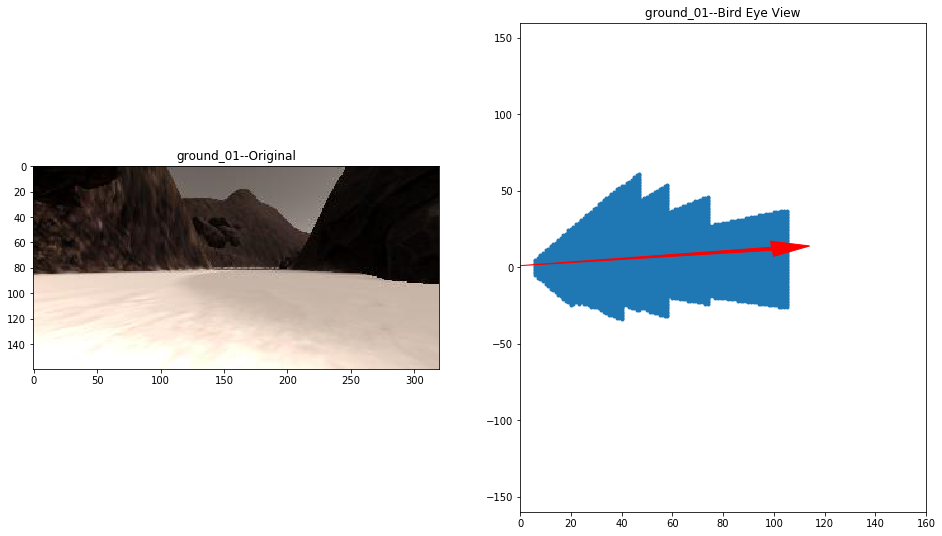

In [17]:
# Visualization:
for test_image_filename in sorted(glob.glob(conf.perspective_transformer_test_images))[:1]:
    # Original & thresholded:
    image_sample_original = cv2.imread(
        test_image_filename
    )
    image_sample_thresholded = binarizer_ground.transform(
        image_sample_original
    )
    image_sample_transformed = transformer.transform(
        image_sample_thresholded
    )
    
    (x_rover, y_rover) = rover_coord_mapper.transform(image_sample_transformed)
    (rho_rover, theta_rover) = rover_polar_mapper.transform((x_rover, y_rover))
    heading_direction = np.mean(theta_rover)
    
    # Initialize canvas:
    coordinate_transformation_demo = plt.figure(figsize=(16, 9))

    # Test image name:
    image_name, _ = splitext(basename(test_image_filename))
    
    # Original:
    ax=coordinate_transformation_demo.add_subplot(1,2,1)
    plt.imshow(
        cv2.cvtColor(
            image_sample_original, 
            cv2.COLOR_BGR2RGB
        )
    )
    ax.set_title("{}--Original".format(image_name))
    # In rover coordinates:
    ax=coordinate_transformation_demo.add_subplot(1,2,2)
    # Bird-eye view:
    plt.plot(x_rover, y_rover, '.')
    plt.ylim(-160, 160)
    plt.xlim(0, 160)
    # Heading direction:
    arrow_length = 100
    x_arrow = arrow_length * np.cos(heading_direction)
    y_arrow = arrow_length * np.sin(heading_direction)
    plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
    ax.set_title("{}--Bird Eye View".format(image_name))

## Mapping on Video Stream

***

Here the utilities for rover state access are all wrapped up and refactored as Python classes

### Initialize Rover State Accessor

In [18]:
# Initialize rover state accessor:
rover_states = DataBucket(
    conf.frame_size,
    conf.frame_view,
    conf.test_dataset_states,
    conf.world_map
)

### Initialize Painters

In [19]:
# Initialize bird eye view painter:
bird_eye_view_painter = BirdEyeViewPainter(
    conf.frame_size
)

In [20]:
# Initialize world map painter:
world_map_painter = WorldMapPainter()

### Video Frame Processor

In [21]:
# Static variable decorator:
def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

# Frame processor:
@static_vars(
    world_map = rover_states.world_map,
    frame_index = 0
)
def process_frame(frame):
    # Format input:
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    # Rover state:
    (x_trans, y_trans, yaw) = rover_states[process_frame.frame_index]

    # Segmented ground:
    ground = transformer.transform(
        binarizer_ground.transform(frame)
    )
    # Segmented obstacle:
    obstacle = (ground == 0).astype(
        np.int
    )
    obstacle[rover_states.rover_view == 0] = 0
    # Segmented rock:
    rock = transformer.transform(
        binarizer_rock.transform(frame)
    )

    # Initialize coordinate transform:
    yaw = np.pi / 180.0 * yaw
    scales = (conf.scale, conf.scale)
    translations= (x_trans, y_trans)

    # Extract coordinates:
    coords = {
        "ground": {},
        "obstacle": {},
        "rock": {}    
    }
    for obj_name, obj_in_pixel in zip(
        ("ground", "obstacle", "rock"),
        (ground, obstacle, rock),
    ):
        coords[obj_name]["rover"] = rover_coord_mapper.transform(obj_in_pixel)
        coords[obj_name]["polar"] = rover_polar_mapper.transform(
            coords[obj_name]["rover"]
        )
        coords[obj_name]["world"] = world_coord_mapper.transform(
            coords[obj_name]["rover"], 
            yaw,
            scales,
            translations
        )

    # Bird eye view:
    bird_eye_view = bird_eye_view_painter.transform(
        coords["ground"]["rover"],
        coords["obstacle"]["rover"],
        coords["rock"]["rover"],
        np.mean(coords["ground"]["polar"][1])
    )

    # World map inpainting:
    process_frame.world_map = world_map_painter.transform(
        process_frame.world_map,
        coords["ground"]["world"],
        coords["obstacle"]["world"],
        coords["rock"]["world"]
    )
    
    # Final output:
    processed = np.zeros(
        (
            frame.shape[0] + process_frame.world_map.shape[0],
            2*frame.shape[1],
            3
        ),
        dtype=np.uint8
    )
    # Input frame:
    processed[
        0:frame.shape[0],
        0:frame.shape[1],
        :
    ] = frame
    # Bird eye view:
    processed[
        0:frame.shape[0],
        frame.shape[1]:,
        :
    ] = bird_eye_view
    # Mapping:
    processed[
        frame.shape[0]:,
        frame.shape[1] - process_frame.world_map.shape[1] // 2:frame.shape[1] + process_frame.world_map.shape[1] // 2,
        :
    ] = np.flipud(process_frame.world_map)    

    # Update index:
    process_frame.frame_index += 1
    
    return cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)

### Make a Video from Processed Image Data

Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.  

In [22]:
# Set up video editing:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML

In [23]:
# Note: output video will be sped up because 
# recording rate in simulator is fps=25
test_clip_input = ImageSequenceClip(rover_states.images, fps=60) 
test_clip_output = test_clip_input.fl_image(process_frame)
%time test_clip_output.write_videofile(conf.test_dataset_output_video, audio=False)

[MoviePy] >>>> Building video output_videos/test_mapping.mp4
[MoviePy] Writing video output_videos/test_mapping.mp4


100%|██████████| 283/283 [00:04<00:00, 59.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_mapping.mp4 

CPU times: user 32.4 s, sys: 12 ms, total: 32.4 s
Wall time: 4.86 s


### Display It

In [24]:
HTML(
"""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
""".format(conf.test_dataset_output_video)
)